# MTA Turnstile Data Analysis
## Benson Challenges
### *With Pandas*

### Table of Contents:
 - [**Challenge 1**](#1)
 - [**Challenge 2**](#2)
 - [**Challenge 3**](#3)
 - [**Challenge 4**](#4)
 - [**Challenge 5**](#5)
 - [**Challenge 6**](#6)
 - [**Challenge 7**](#7)
 - [**Challenge 8**](#8)
 - [**Challenge 9**](#9)
 - [**Challenge 10**](#10)

In [17]:
# Import Dependencies
import pandas as pd  #
import numpy as np    # Arrays and matrices
from GetDataURLs import GetDataURLs
import csv
import dateutil.parser

# For display
import pprint
import matplotlib.pyplot as plt
%matplotlib inline

### <a id='1'></a>Challenge 1:

In [58]:
def download_and_process_raw_data(raw_HTML_data_URLs):
    """
    In: 
    raw_HTML_data_URLs = A .txt file with unparsed HTML code containing the desired URLs to the data
    
    Out:
    df = A pandas dataframe with the raw data
    """
    
    # Parse raw HTML using regular expressions to get URLs to data files
    link_list = GetDataURLs(raw_HTML_data_URLs)
    
    #Split each URL by "/" and take the last item to the file name and extension without the past (e.g. "data.txt")
    file_list = [link.split("/")[-1] for link in link_list]
    
    all_rows = []
    headers = ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES', 'EXITS']

    
    for link, file in zip(link_list, file_list):
        """
        Download the raw data
        
        To save time do this ONLY ONCE, and then comment out!
        """
        # !curl -O http://web.mta.info/developers/$link

        # Open files from the "data" folder
        with open("./data/" + file) as f:
            reader = csv.reader(f)
            rows = [[cell.strip() for cell in row] for row in reader]

        
        # Check that the data file headers are correct and remove
        assert rows.pop(0) == headers
        
        for row in rows:
            all_rows.append(row)

    df = pd.DataFrame(all_rows, columns=headers)
    
    return df

raw_df = download_and_process_raw_data("rawHTMLdataURLs.txt")

In [60]:
def fix_linename_order(df):
    """
    In:
    df = pandas dataframe with raw data
    
    Out:
    Returns pandas dataframe with the order of linename made consistent (e.g. 123ABC instead of 3C12BA)
    """
    df["LINENAME"] = df["LINENAME"].apply(lambda x: "".join(sorted([c for c in x])))
    return df
    
processed_df = fix_linename_order(raw_df)

In [62]:
def make_key(df):
    """
    In:
    df = pandas dataframe with fixed linename order
    
    Out:
    Returns pandas dataframe with new KEY field that is a tuple of ("C/A", "UNIT", "SCP", "STATION", "LINENAME")
    """
    df["KEY"] = tuple(zip(df["C/A"], df["UNIT"], df["SCP"], df["STATION"], df["LINENAME"]))
    
    return df

processed_df = make_key(processed_df)

### <a id='2'></a>Challenge 2:

In [64]:
def add_timestamps(df):
    """
    In:
    df = pandas dataframe with fixed linename order, and key
    
    Out:
    Returns pandas dataframe with new DATETIME field that is a datetime of DATE and TIME combined
    """
    df["DATETIME"] = df["DATE"] + " " + df["TIME"]
    # df["DATETIME"] = pd.to_datetime(df["DATETIME"])
    df["DATETIME"] = df["DATETIME"].apply(lambda x: dateutil.parser.parse(x))
    
    return df

processed_df = add_timestamps(processed_df)

In [124]:
def get_net_entries(df):
    """
    In:
    df = dataframe object with TIME and DATE converted to DATETIME for each turnstile measurement
    
    Out:
    new_df = a pandas dataframe with the raw entries totals converted to a net entry count since the previous report
    """
    df["ENTRIES"] = df["ENTRIES"].apply(lambda x: int(x))
    all_data_list = []
    headers = ""
    i = 0
    
    by_turnstile = df.groupby("KEY")
    for turnstile, data in by_turnstile:
        data = data.sort(["DATETIME"])
        data["SHIFTED"] = data["ENTRIES"].shift()
        data["NET_ENTRIES"] = data["ENTRIES"] - data["SHIFTED"]
        data["NET_ENTRIES"].fillna(0, inplace=True)
        
        if i == 0:
            headers = list(data.columns)
            i += 1
        
        data_as_list = data.values.tolist()
        for row in data_as_list:
            all_data_list.append(row)
        
    new_df = pd.DataFrame(all_data_list, columns=headers)
    return new_df

processed_df = get_net_entries(processed_df)

In [133]:
def remove_entry_count_outliers(df):
    """
    In: 
    df = processed pandas dataframe with net entry counts rather than raw totals
    
    Out: 
    new dictionary removing outliers (negative entries or over 10,000 entries per 4 hours)
    """
    return df[(0 <= df["NET_ENTRIES"]) & (df["NET_ENTRIES"] <= 10000)]

outliers_removed_df = remove_entry_count_outliers(processed_df)

In [137]:
def cleanup_df(df):
    """
    In:
    df = processed pandas dataframe with datetimes, net entry counts, and outliers removed 
    
    Out:
    Returns a pandas dataframe removing old and unneeded columns
    """
    return df[["KEY", "DATETIME", "NET_ENTRIES"]]

cleaned_df = cleanup_df(outliers_removed_df)

### <a id='3'></a>Challenge 3:
The counts (for the majority of data points) are for **every 4 hours** (though there are some turnstiles reporting longer or shorter times between reports).

In [159]:
def datetime_to_date(dt):
        """
        In:
        dt = datetime.datetime object
        
        Out:
        date = datetime.date object (unlike .date() converted with error handling)
        """
        try:
            date = dt.date()
        except AttributeError:
            date = dt  # If object is already a date, no need to call .date()
        return date

In [208]:
def roll_up_by_date(df):
    """
    In:
    df = processed pandas dataframe with net entry counts rather than raw totals and outliers removed
    
    Out:
    new_df = new pandas dataframe with all the readings within each date combined for each key (turnstile)
    """    
    df["DATETIME"].apply(datetime_to_date)
    by_turnstile_and_date = df.groupby(["KEY", "DATETIME"])
    new_df = by_turnstile_and_date["NET_ENTRIES"].sum()            
    new_df = pd.DataFrame(new_df)
    
    new_df.reset_index(level=0, inplace=True)
    new_df.reset_index(level=0, inplace=True)
    
    return new_df

grouped_dates_df = roll_up_by_date(cleaned_df)

### <a id='4'></a>Challenge 4:

In [180]:
# See begining of file for the "%matplotlib inline" and "import matplotlib.pyplot as plt"

def get_by_date_plot_data(df, k):
    """
    In:
    df = pandas dataframe with grouped dates for each turnstile
    k = key (e.g. turnstile, station, etc.) whose data you want to plot
    
    Out:
    (dates, counts) = tuple with dates and entry counts for plotting
    """
    sub_df = df[df["KEY"] == k]
    
    dates = sub_df["DATETIME"].values
    counts = sub_df["NET_ENTRIES"].values
    return dates, counts

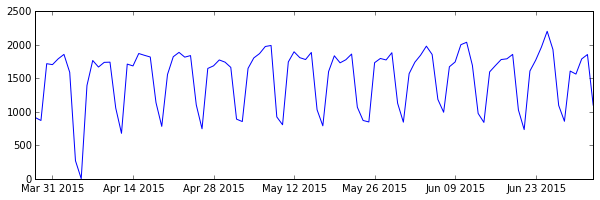

In [181]:
def plot_time_series(datetimes, counts):
    """
    In:
    datetimes = list of dates and/or times to plot (x-axis values)
    counts = list of counts or other data to plot (y-axis values)
    
    Out:
    Plot of counts by datetime
    """
    plt.figure(figsize=(10,3))
    plt.plot(datetimes, counts)
    
dates, counts = get_by_date_plot_data(grouped_dates_df, grouped_dates_df["KEY"][0])
plot_time_series(dates, counts)

### <a id='5'></a>Challenge 5:

In [210]:
def roll_up_SCPs(df):
    """
    In:
    df = processed pandas dataframe grouped by date for each turnstile
    
    Out:
    new_df = pandas dataframe rolling up individual turnstiles to the ("C/A", "UNIT", "STATION", "LINENAME") level
    """
    df["SCP"] = df["KEY"].apply(lambda x: x[2])
    df["KEY"] = df["KEY"].apply(lambda x: tuple(x[:2] + x[-2:]))
    
    # Re-combine dates since there will now be multiple instances of each date again given the SCP roll up
    new_df = roll_up_by_date(df) 
    
    return new_df[["KEY", "DATETIME", "NET_ENTRIES"]]

SCPs_rolled_df = roll_up_SCPs(grouped_dates_df)

### <a id='6'></a>Challenge 6:

In [212]:
def roll_up_to_stations(df):
    """
    In:
    df = processed pandas dataframe grouped by date with rolled up turnstile SCPs
    
    Out:
    new_df = pandas dataframe rolling up all turnstiles to the STATION - LINENAME" level
    """
    df["C/A_UNIT"] = df["KEY"].apply(lambda x: x[:2])
    df["KEY"] = df["KEY"].apply(lambda x: tuple(x[-2:]))
    
    # Re-combine dates since there will now be multiple instances of each date again given the SCP roll up
    new_df = roll_up_by_date(df) 
    
    return new_df[["KEY", "DATETIME", "NET_ENTRIES"]]

by_station_df = roll_up_to_stations(SCPs_rolled_df)

### <a id='7'></a>Challenge 7:

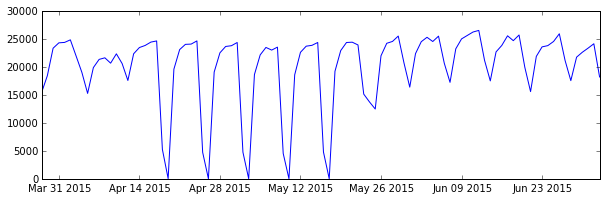

In [220]:
dates, counts = get_by_date_plot_data(by_station_df, by_station_df["KEY"][0])
plot_time_series(dates, counts)

### <a id='8'></a>Challenge 8:

In [ ]:
def split_station_into_weekly_lists(df, station):
    """
    In:
    df = processed python dataframe grouped by date, rolled up by station
    station = station for which you want get weekly lists of entry counts by day
    
    Out:
    list_of_weekly_entries = list of weekly lists of count of entries (Sunday - Saturday)
    """
    station_df = df[df["KEY"] == station]
    station_df["DAY"] = station_df["DATETIME"].apply(lambda x: x.weekday())
    station_df["NEW_WEEK"] = station_df["DAY"].apply(lambda x: 1 if x == 6 else 0)
    station_df["WEEK"] = station_df["NEW_WEEK"].cumsum()
    
    by_week = station_df.groupby("WEEK")
    list_of_weekly_entries = []
    for week, data in by_week:
        week_entries = []
        week_entries += list(data["NET_ENTRIES"].values)

        if week == 0:
            days_ahead = 7 - len(week_entries)
            week_entries = ([0] * days_ahead) + week_entries
        elif len(week_entries) != 7:
            days_behind = 7 - len(week_entries)
            week_entries = week_entries + ([0] * days_behind)
            
        list_of_weekly_entries.append(week_entries)
    
    return list_of_weekly_entries

weekly_lists = split_station_into_weekly_lists(by_station_df, by_station_df["KEY"][0])

In [243]:
def get_by_weekday_plot_data(one_week_list):
    """
    In:
    one_week_list = list of counts corresponding to each weekday Sunday - Saturday
    
    Out:
    (weekydays, counts) = tuple of weekday numbers and counts to plot
    """
    # weekdays = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
    weekdays = [x + 1 for x in range(7)]
    counts = one_week_list
    return weekdays, counts

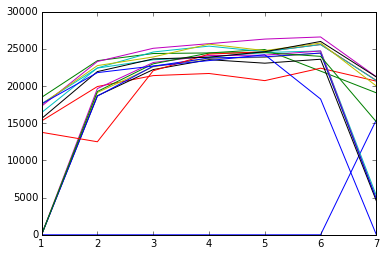

In [244]:
def plot_weekly_rainbow_chart(weekly_lists):
    """
    In:
    weekly_lists = list of weekly lists of count of entries (Sunday - Saturday) to be plotted
    
    Out:
    "Rainbow" chart plot
    """
    for week in weekly_lists:
        weekdays, counts = get_by_weekday_plot_data(week)
        plt.plot(weekdays, counts)

plot_weekly_rainbow_chart(weekly_lists)

### <a id='9'></a>Challenge 9:

In [253]:
def roll_all_dates_by_stations(df):
    """
    In:
    df = processed pandas dataframe grouped by date with rolled up stations
    
    Out:
    new_df = pandas dataframe with all dates rolled up to a single value for each station
    """
    by_station = df.groupby("KEY")
    new_df = by_station["NET_ENTRIES"].sum()
    new_df.sort("NET_ENTRIES", ascending=False, inplace=True)
    new_df = pd.DataFrame(new_df)
    new_df.reset_index(level=0, inplace=True)
    return new_df

all_dates_rolled = roll_all_dates_by_stations(by_station_df)

### <a id='10'></a>Challenge 10:

(array([ 359.,   76.,   16.,    6.,    3.,    3.,    1.,    1.,    1.,    1.]),
 array([  8.45700000e+03,   1.29658760e+06,   2.58471820e+06,
          3.87284880e+06,   5.16097940e+06,   6.44911000e+06,
          7.73724060e+06,   9.02537120e+06,   1.03135018e+07,
          1.16016324e+07,   1.28897630e+07]),
 <a list of 10 Patch objects>)

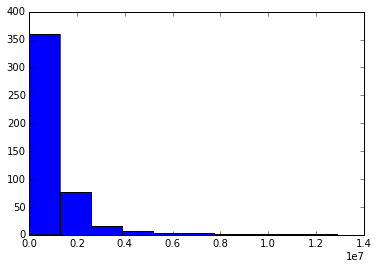

In [255]:
counts = all_dates_rolled["NET_ENTRIES"].values
plt.hist(counts)

<Container object of 467 artists>

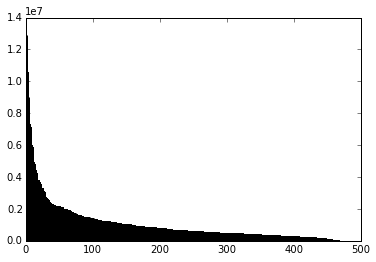

In [256]:
indices = range(1, len(counts) + 1)
plt.bar(indices, counts)